# Overview of this jupyter notebook

1. Loading the data
2. Hyperparameter optimization for SVM Model
3. Evaluation of the optimized model and saving the results

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 60)
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import cross_val_predict
from skmultilearn.problem_transform import BinaryRelevance
from tqdm.notebook import tqdm_notebook as tq
from warnings import filterwarnings
filterwarnings('ignore')
import pickle
import json
import random

In [2]:
import os
import importlib
from library import faps_color as fapsc        # this module contains the color combination of FAPS Institute
from library import classification_helper as ch  # this module contains helper functions for the classification task
print(importlib.reload(fapsc))
print(importlib.reload(ch))

<module 'library.faps_color' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\faps_color.py'>
<module 'library.classification_helper' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. MA_FAPS\\04_Code\\library\\classification_helper.py'>


In [3]:
!python -V

Python 3.10.6


# 1. Loading the data

In [4]:
classes = ['0_in_ordnung',
           '1_kleine_durchgangsbohrung',
           '2_versetzte_fuegepartner',
           '3_unebene_fuegeflaeche',
           '4_span_im_gewinde',
           '5_verschmutzte_schraube',
           '6_fremdkoerper_am_gewindeende',
           '7_beschaedigte_schraube']

In [5]:
feature_train = pd.read_pickle("feature_label/mlc_feature_train_tsfresh_2.4.pkl")
feature_train.shape

(1550, 789)

In [6]:
feature_test = pd.read_pickle("feature_label/mlc_feature_test_tsfresh_2.4.pkl")
feature_test.shape

(750, 789)

In [7]:
label_train = pd.read_pickle("feature_label/mlc_label_train_tsfresh_v2.4.pkl")
label_train.shape

(1550, 8)

In [8]:
label_test = pd.read_pickle("feature_label/mlc_label_test_tsfresh_v2.4.pkl")
label_test.shape

(750, 8)

In [9]:
# relevance table has the information about which feature is relevant for the classification task based on p-value

relevance_table = pd.read_pickle("feature_label/mlc_relevance_table_tsfresh_v2.4.pkl")
relevance_table

,feature,type,p_value_0,relevant_0,p_value_1,relevant_1,p_value_2,relevant_2,p_value_3,relevant_3,p_value_4,relevant_4,p_value_5,relevant_5,p_value_6,relevant_6,p_value_7,relevant_7,p_value_8,relevant_8,p_value_9,relevant_9,p_value_10,relevant_10,p_value_11,relevant_11,p_value_12,relevant_12,p_value_13,relevant_13,p_value_14,relevant_14,n_significant,relevant
feature,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
torque__variation_coefficient,torque__variation_coefficient,real,5.197543e-90,True,1.643083e-07,True,5.144671e-13,True,6.022008e-41,True,2.678407e-11,True,3.459922e-02,False,2.137971e-29,True,6.742358e-25,True,5.705008e-03,False,3.158111e-14,True,1.457102e-25,True,1.597761e-07,True,0.029758,False,1.769481e-17,True,0.002942,False,11,True
torque__lempel_ziv_complexity__bins_100,torque__lempel_ziv_complexity__bins_100,real,5.463394e-90,True,9.139738e-09,True,1.787593e-16,True,2.365570e-50,True,2.081732e-21,True,5.843446e-19,True,3.908102e-07,True,4.137441e-09,True,1.990712e-16,True,2.544483e-12,True,4.183211e-17,True,4.656514e-06,True,0.072377,False,1.791119e-30,True,0.000034,True,14,True
torque__mean,torque__mean,real,9.576607e-90,True,2.213726e-06,True,2.304176e-11,True,6.607692e-39,True,3.657118e-13,True,4.674008e-03,False,4.020447e-35,True,1.552304e-34,True,4.396053e-02,False,5.792276e-13,True,9.756297e-24,True,4.440944e-07,True,0.000483,True,7.502963e-16,True,0.000886,True,13,True
"torque__fft_coefficient__attr_""abs""__coeff_0","torque__fft_coefficient__attr_""abs""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
"torque__fft_coefficient__attr_""real""__coeff_0","torque__fft_coefficient__attr_""real""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
torque__friedrich_coefficients__coeff_3__m_3__r_30,torque__friedrich_coefficients__coeff_3__m_3__...,constant,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,0,False
torque__max_langevin_fixed_point__m_3__r_30,torque__max_langevin_fixed_point__m_3__r_30,constant,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,0,False
torque__number_crossing_m__m_-1,torque__number_crossing_m__m_-1,constant,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,0,False


In [10]:
relevance_table = relevance_table[relevance_table.relevant==True]
relevance_table

,feature,type,p_value_0,relevant_0,p_value_1,relevant_1,p_value_2,relevant_2,p_value_3,relevant_3,p_value_4,relevant_4,p_value_5,relevant_5,p_value_6,relevant_6,p_value_7,relevant_7,p_value_8,relevant_8,p_value_9,relevant_9,p_value_10,relevant_10,p_value_11,relevant_11,p_value_12,relevant_12,p_value_13,relevant_13,p_value_14,relevant_14,n_significant,relevant
feature,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
torque__variation_coefficient,torque__variation_coefficient,real,5.197543e-90,True,1.643083e-07,True,5.144671e-13,True,6.022008e-41,True,2.678407e-11,True,3.459922e-02,False,2.137971e-29,True,6.742358e-25,True,5.705008e-03,False,3.158111e-14,True,1.457102e-25,True,1.597761e-07,True,0.029758,False,1.769481e-17,True,0.002942,False,11,True
torque__lempel_ziv_complexity__bins_100,torque__lempel_ziv_complexity__bins_100,real,5.463394e-90,True,9.139738e-09,True,1.787593e-16,True,2.365570e-50,True,2.081732e-21,True,5.843446e-19,True,3.908102e-07,True,4.137441e-09,True,1.990712e-16,True,2.544483e-12,True,4.183211e-17,True,4.656514e-06,True,0.072377,False,1.791119e-30,True,0.000034,True,14,True
torque__mean,torque__mean,real,9.576607e-90,True,2.213726e-06,True,2.304176e-11,True,6.607692e-39,True,3.657118e-13,True,4.674008e-03,False,4.020447e-35,True,1.552304e-34,True,4.396053e-02,False,5.792276e-13,True,9.756297e-24,True,4.440944e-07,True,0.000483,True,7.502963e-16,True,0.000886,True,13,True
"torque__fft_coefficient__attr_""abs""__coeff_0","torque__fft_coefficient__attr_""abs""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
"torque__fft_coefficient__attr_""real""__coeff_0","torque__fft_coefficient__attr_""real""__coeff_0",real,9.576613e-90,True,2.214774e-06,True,2.302666e-11,True,6.591071e-39,True,3.654522e-13,True,4.669805e-03,False,4.015649e-35,True,1.552305e-34,True,4.392685e-02,False,5.792276e-13,True,9.724570e-24,True,4.452156e-07,True,0.000483,True,7.512830e-16,True,0.000887,True,13,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"torque__fft_coefficient__attr_""imag""__coeff_92","torque__fft_coefficient__attr_""imag""__coeff_92",real,9.478897e-01,False,1.716470e-01,False,9.849157e-01,False,1.072699e-04,True,8.559883e-01,False,5.015247e-01,False,1.822312e-01,False,4.250886e-01,False,4.911643e-01,False,1.170838e-02,False,1.711853e-01,False,8.991722e-01,False,0.025441,False,7.237413e-01,False,0.292634,False,1,True
"torque__cwt_coefficients__coeff_12__w_2__widths_(2, 5, 10, 20)",torque__cwt_coefficients__coeff_12__w_2__width...,real,9.544628e-01,False,2.995364e-12,True,1.424985e-01,False,3.158056e-02,False,4.182010e-03,False,5.572269e-01,False,1.291619e-01,False,2.636988e-01,False,2.499537e-07,True,2.074936e-01,False,6.579449e-01,False,8.661737e-02,False,0.083162,False,6.838159e-01,False,0.142855,False,2,True
"torque__fft_coefficient__attr_""real""__coeff_91","torque__fft_coefficient__attr_""real""__coeff_91",real,9.748111e-01,False,1.528592e-01,False,9.135638e-01,False,2.650780e-05,True,9.138683e-01,False,6.113325e-01,False,5.596143e-01,False,2.779372e-01,False,4.141510e-01,False,1.277503e-02,False,1.527884e-01,False,7.170111e-01,False,0.003934,False,5.555035e-01,False,0.163287,False,1,True


In [13]:
relevant_feature = list(relevance_table[relevance_table.relevant==True].feature)
len(relevant_feature)

615

In [14]:
feat_train = feature_train[relevant_feature]
feat_test = feature_test[relevant_feature]
feat_train.shape, feat_test.shape

((1550, 615), (750, 615))

In [15]:
lab_train = label_train.values
lab_test = label_test.values
lab_train.shape, lab_test.shape

((1550, 8), (750, 8))

In [16]:
from sklearn.utils import shuffle

x_train, y_train = shuffle(feat_train, lab_train, random_state=9)
x_test, y_test = shuffle(feat_test, lab_test, random_state=9)

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
y_test

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [17]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1550, 615), (1550, 8), (750, 615), (750, 8))

# 2. Hyperparameter optimization for SVM Model

In [23]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC

In [42]:
parameters={'classifier__kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'classifier__C':[0.01, 0.1, 1.0, 10, 50, 100],
            'classifier__gamma':['scale', 'auto', 0.0001, 0.001, 0.01, 0.1, 1, 10]}

search = GridSearchCV(BinaryRelevance(SVC()), parameters, cv=5, scoring='accuracy', verbose=10)
search.fit(x_train, y_train)
print(search.best_score_, search.best_params_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV 1/5; 1/192] START classifier__C=0.01, classifier__gamma=scale, classifier__kernel=linear
[CV 1/5; 1/192] END classifier__C=0.01, classifier__gamma=scale, classifier__kernel=linear;, score=0.729 total time=  37.7s
[CV 2/5; 1/192] START classifier__C=0.01, classifier__gamma=scale, classifier__kernel=linear
[CV 2/5; 1/192] END classifier__C=0.01, classifier__gamma=scale, classifier__kernel=linear;, score=0.726 total time=  28.1s
[CV 3/5; 1/192] START classifier__C=0.01, classifier__gamma=scale, classifier__kernel=linear
[CV 3/5; 1/192] END classifier__C=0.01, classifier__gamma=scale, classifier__kernel=linear;, score=0.748 total time=  25.6s
[CV 4/5; 1/192] START classifier__C=0.01, classifier__gamma=scale, classifier__kernel=linear
[CV 4/5; 1/192] END classifier__C=0.01, classifier__gamma=scale, classifier__kernel=linear;, score=0.748 total time=  37.6s
[CV 5/5; 1/192] START classifier__C=0.01, classifier__gamma=scale, cl

[CV 4/5; 8/192] END classifier__C=0.01, classifier__gamma=auto, classifier__kernel=sigmoid;, score=0.000 total time=   1.2s
[CV 5/5; 8/192] START classifier__C=0.01, classifier__gamma=auto, classifier__kernel=sigmoid
[CV 5/5; 8/192] END classifier__C=0.01, classifier__gamma=auto, classifier__kernel=sigmoid;, score=0.000 total time=   1.2s
[CV 1/5; 9/192] START classifier__C=0.01, classifier__gamma=0.0001, classifier__kernel=linear
[CV 1/5; 9/192] END classifier__C=0.01, classifier__gamma=0.0001, classifier__kernel=linear;, score=0.729 total time=  36.2s
[CV 2/5; 9/192] START classifier__C=0.01, classifier__gamma=0.0001, classifier__kernel=linear
[CV 2/5; 9/192] END classifier__C=0.01, classifier__gamma=0.0001, classifier__kernel=linear;, score=0.726 total time=  27.5s
[CV 3/5; 9/192] START classifier__C=0.01, classifier__gamma=0.0001, classifier__kernel=linear
[CV 3/5; 9/192] END classifier__C=0.01, classifier__gamma=0.0001, classifier__kernel=linear;, score=0.748 total time=  25.9s
[C

[CV 2/5; 16/192] END classifier__C=0.01, classifier__gamma=0.001, classifier__kernel=sigmoid;, score=0.000 total time=   1.2s
[CV 3/5; 16/192] START classifier__C=0.01, classifier__gamma=0.001, classifier__kernel=sigmoid
[CV 3/5; 16/192] END classifier__C=0.01, classifier__gamma=0.001, classifier__kernel=sigmoid;, score=0.000 total time=   1.1s
[CV 4/5; 16/192] START classifier__C=0.01, classifier__gamma=0.001, classifier__kernel=sigmoid
[CV 4/5; 16/192] END classifier__C=0.01, classifier__gamma=0.001, classifier__kernel=sigmoid;, score=0.000 total time=   1.2s
[CV 5/5; 16/192] START classifier__C=0.01, classifier__gamma=0.001, classifier__kernel=sigmoid
[CV 5/5; 16/192] END classifier__C=0.01, classifier__gamma=0.001, classifier__kernel=sigmoid;, score=0.000 total time=   1.3s
[CV 1/5; 17/192] START classifier__C=0.01, classifier__gamma=0.01, classifier__kernel=linear
[CV 1/5; 17/192] END classifier__C=0.01, classifier__gamma=0.01, classifier__kernel=linear;, score=0.729 total time=  

[CV 1/5; 24/192] END classifier__C=0.01, classifier__gamma=0.1, classifier__kernel=sigmoid;, score=0.000 total time=   1.1s
[CV 2/5; 24/192] START classifier__C=0.01, classifier__gamma=0.1, classifier__kernel=sigmoid
[CV 2/5; 24/192] END classifier__C=0.01, classifier__gamma=0.1, classifier__kernel=sigmoid;, score=0.000 total time=   1.1s
[CV 3/5; 24/192] START classifier__C=0.01, classifier__gamma=0.1, classifier__kernel=sigmoid
[CV 3/5; 24/192] END classifier__C=0.01, classifier__gamma=0.1, classifier__kernel=sigmoid;, score=0.000 total time=   1.1s
[CV 4/5; 24/192] START classifier__C=0.01, classifier__gamma=0.1, classifier__kernel=sigmoid
[CV 4/5; 24/192] END classifier__C=0.01, classifier__gamma=0.1, classifier__kernel=sigmoid;, score=0.000 total time=   1.1s
[CV 5/5; 24/192] START classifier__C=0.01, classifier__gamma=0.1, classifier__kernel=sigmoid
[CV 5/5; 24/192] END classifier__C=0.01, classifier__gamma=0.1, classifier__kernel=sigmoid;, score=0.000 total time=   1.1s
[CV 1/5;

[CV 5/5; 31/192] END classifier__C=0.01, classifier__gamma=10, classifier__kernel=rbf;, score=0.000 total time=   7.2s
[CV 1/5; 32/192] START classifier__C=0.01, classifier__gamma=10, classifier__kernel=sigmoid
[CV 1/5; 32/192] END classifier__C=0.01, classifier__gamma=10, classifier__kernel=sigmoid;, score=0.000 total time=   1.5s
[CV 2/5; 32/192] START classifier__C=0.01, classifier__gamma=10, classifier__kernel=sigmoid
[CV 2/5; 32/192] END classifier__C=0.01, classifier__gamma=10, classifier__kernel=sigmoid;, score=0.000 total time=   1.6s
[CV 3/5; 32/192] START classifier__C=0.01, classifier__gamma=10, classifier__kernel=sigmoid
[CV 3/5; 32/192] END classifier__C=0.01, classifier__gamma=10, classifier__kernel=sigmoid;, score=0.000 total time=   1.5s
[CV 4/5; 32/192] START classifier__C=0.01, classifier__gamma=10, classifier__kernel=sigmoid
[CV 4/5; 32/192] END classifier__C=0.01, classifier__gamma=10, classifier__kernel=sigmoid;, score=0.000 total time=   1.6s
[CV 5/5; 32/192] STAR

[CV 4/5; 39/192] END classifier__C=0.1, classifier__gamma=auto, classifier__kernel=rbf;, score=0.000 total time=   6.8s
[CV 5/5; 39/192] START classifier__C=0.1, classifier__gamma=auto, classifier__kernel=rbf
[CV 5/5; 39/192] END classifier__C=0.1, classifier__gamma=auto, classifier__kernel=rbf;, score=0.000 total time=   7.0s
[CV 1/5; 40/192] START classifier__C=0.1, classifier__gamma=auto, classifier__kernel=sigmoid
[CV 1/5; 40/192] END classifier__C=0.1, classifier__gamma=auto, classifier__kernel=sigmoid;, score=0.000 total time=   1.7s
[CV 2/5; 40/192] START classifier__C=0.1, classifier__gamma=auto, classifier__kernel=sigmoid
[CV 2/5; 40/192] END classifier__C=0.1, classifier__gamma=auto, classifier__kernel=sigmoid;, score=0.000 total time=   1.6s
[CV 3/5; 40/192] START classifier__C=0.1, classifier__gamma=auto, classifier__kernel=sigmoid
[CV 3/5; 40/192] END classifier__C=0.1, classifier__gamma=auto, classifier__kernel=sigmoid;, score=0.000 total time=   1.5s
[CV 4/5; 40/192] STA

[CV 2/5; 47/192] END classifier__C=0.1, classifier__gamma=0.001, classifier__kernel=rbf;, score=0.000 total time=   5.4s
[CV 3/5; 47/192] START classifier__C=0.1, classifier__gamma=0.001, classifier__kernel=rbf
[CV 3/5; 47/192] END classifier__C=0.1, classifier__gamma=0.001, classifier__kernel=rbf;, score=0.000 total time=   5.4s
[CV 4/5; 47/192] START classifier__C=0.1, classifier__gamma=0.001, classifier__kernel=rbf
[CV 4/5; 47/192] END classifier__C=0.1, classifier__gamma=0.001, classifier__kernel=rbf;, score=0.000 total time=   5.4s
[CV 5/5; 47/192] START classifier__C=0.1, classifier__gamma=0.001, classifier__kernel=rbf
[CV 5/5; 47/192] END classifier__C=0.1, classifier__gamma=0.001, classifier__kernel=rbf;, score=0.000 total time=   5.3s
[CV 1/5; 48/192] START classifier__C=0.1, classifier__gamma=0.001, classifier__kernel=sigmoid
[CV 1/5; 48/192] END classifier__C=0.1, classifier__gamma=0.001, classifier__kernel=sigmoid;, score=0.000 total time=   1.2s
[CV 2/5; 48/192] START clas

[CV 1/5; 55/192] END classifier__C=0.1, classifier__gamma=0.1, classifier__kernel=rbf;, score=0.000 total time=   5.4s
[CV 2/5; 55/192] START classifier__C=0.1, classifier__gamma=0.1, classifier__kernel=rbf
[CV 2/5; 55/192] END classifier__C=0.1, classifier__gamma=0.1, classifier__kernel=rbf;, score=0.000 total time=   5.3s
[CV 3/5; 55/192] START classifier__C=0.1, classifier__gamma=0.1, classifier__kernel=rbf
[CV 3/5; 55/192] END classifier__C=0.1, classifier__gamma=0.1, classifier__kernel=rbf;, score=0.000 total time=   5.3s
[CV 4/5; 55/192] START classifier__C=0.1, classifier__gamma=0.1, classifier__kernel=rbf
[CV 4/5; 55/192] END classifier__C=0.1, classifier__gamma=0.1, classifier__kernel=rbf;, score=0.000 total time=   5.3s
[CV 5/5; 55/192] START classifier__C=0.1, classifier__gamma=0.1, classifier__kernel=rbf
[CV 5/5; 55/192] END classifier__C=0.1, classifier__gamma=0.1, classifier__kernel=rbf;, score=0.000 total time=   5.3s
[CV 1/5; 56/192] START classifier__C=0.1, classifier_

[CV 1/5; 63/192] END classifier__C=0.1, classifier__gamma=10, classifier__kernel=rbf;, score=0.000 total time=   5.9s
[CV 2/5; 63/192] START classifier__C=0.1, classifier__gamma=10, classifier__kernel=rbf
[CV 2/5; 63/192] END classifier__C=0.1, classifier__gamma=10, classifier__kernel=rbf;, score=0.000 total time=   5.9s
[CV 3/5; 63/192] START classifier__C=0.1, classifier__gamma=10, classifier__kernel=rbf
[CV 3/5; 63/192] END classifier__C=0.1, classifier__gamma=10, classifier__kernel=rbf;, score=0.000 total time=   5.8s
[CV 4/5; 63/192] START classifier__C=0.1, classifier__gamma=10, classifier__kernel=rbf
[CV 4/5; 63/192] END classifier__C=0.1, classifier__gamma=10, classifier__kernel=rbf;, score=0.000 total time=   5.8s
[CV 5/5; 63/192] START classifier__C=0.1, classifier__gamma=10, classifier__kernel=rbf
[CV 5/5; 63/192] END classifier__C=0.1, classifier__gamma=10, classifier__kernel=rbf;, score=0.000 total time=   5.3s
[CV 1/5; 64/192] START classifier__C=0.1, classifier__gamma=10

[CV 5/5; 70/192] END classifier__C=1.0, classifier__gamma=auto, classifier__kernel=poly;, score=0.748 total time=   5.6s
[CV 1/5; 71/192] START classifier__C=1.0, classifier__gamma=auto, classifier__kernel=rbf
[CV 1/5; 71/192] END classifier__C=1.0, classifier__gamma=auto, classifier__kernel=rbf;, score=0.000 total time=   5.4s
[CV 2/5; 71/192] START classifier__C=1.0, classifier__gamma=auto, classifier__kernel=rbf
[CV 2/5; 71/192] END classifier__C=1.0, classifier__gamma=auto, classifier__kernel=rbf;, score=0.000 total time=   5.4s
[CV 3/5; 71/192] START classifier__C=1.0, classifier__gamma=auto, classifier__kernel=rbf
[CV 3/5; 71/192] END classifier__C=1.0, classifier__gamma=auto, classifier__kernel=rbf;, score=0.000 total time=   5.6s
[CV 4/5; 71/192] START classifier__C=1.0, classifier__gamma=auto, classifier__kernel=rbf
[CV 4/5; 71/192] END classifier__C=1.0, classifier__gamma=auto, classifier__kernel=rbf;, score=0.000 total time=   5.4s
[CV 5/5; 71/192] START classifier__C=1.0, c

[CV 3/5; 78/192] END classifier__C=1.0, classifier__gamma=0.001, classifier__kernel=poly;, score=0.758 total time=   6.3s
[CV 4/5; 78/192] START classifier__C=1.0, classifier__gamma=0.001, classifier__kernel=poly
[CV 4/5; 78/192] END classifier__C=1.0, classifier__gamma=0.001, classifier__kernel=poly;, score=0.745 total time=   6.2s
[CV 5/5; 78/192] START classifier__C=1.0, classifier__gamma=0.001, classifier__kernel=poly
[CV 5/5; 78/192] END classifier__C=1.0, classifier__gamma=0.001, classifier__kernel=poly;, score=0.748 total time=   5.6s
[CV 1/5; 79/192] START classifier__C=1.0, classifier__gamma=0.001, classifier__kernel=rbf
[CV 1/5; 79/192] END classifier__C=1.0, classifier__gamma=0.001, classifier__kernel=rbf;, score=0.000 total time=   5.4s
[CV 2/5; 79/192] START classifier__C=1.0, classifier__gamma=0.001, classifier__kernel=rbf
[CV 2/5; 79/192] END classifier__C=1.0, classifier__gamma=0.001, classifier__kernel=rbf;, score=0.000 total time=   5.4s
[CV 3/5; 79/192] START classif

[CV 2/5; 86/192] END classifier__C=1.0, classifier__gamma=0.1, classifier__kernel=poly;, score=0.748 total time=   6.5s
[CV 3/5; 86/192] START classifier__C=1.0, classifier__gamma=0.1, classifier__kernel=poly
[CV 3/5; 86/192] END classifier__C=1.0, classifier__gamma=0.1, classifier__kernel=poly;, score=0.758 total time=   5.4s
[CV 4/5; 86/192] START classifier__C=1.0, classifier__gamma=0.1, classifier__kernel=poly
[CV 4/5; 86/192] END classifier__C=1.0, classifier__gamma=0.1, classifier__kernel=poly;, score=0.745 total time=   6.1s
[CV 5/5; 86/192] START classifier__C=1.0, classifier__gamma=0.1, classifier__kernel=poly
[CV 5/5; 86/192] END classifier__C=1.0, classifier__gamma=0.1, classifier__kernel=poly;, score=0.752 total time=   5.5s
[CV 1/5; 87/192] START classifier__C=1.0, classifier__gamma=0.1, classifier__kernel=rbf
[CV 1/5; 87/192] END classifier__C=1.0, classifier__gamma=0.1, classifier__kernel=rbf;, score=0.000 total time=   5.4s
[CV 2/5; 87/192] START classifier__C=1.0, clas

[CV 2/5; 94/192] END classifier__C=1.0, classifier__gamma=10, classifier__kernel=poly;, score=0.752 total time=   7.6s
[CV 3/5; 94/192] START classifier__C=1.0, classifier__gamma=10, classifier__kernel=poly
[CV 3/5; 94/192] END classifier__C=1.0, classifier__gamma=10, classifier__kernel=poly;, score=0.761 total time=   7.1s
[CV 4/5; 94/192] START classifier__C=1.0, classifier__gamma=10, classifier__kernel=poly
[CV 4/5; 94/192] END classifier__C=1.0, classifier__gamma=10, classifier__kernel=poly;, score=0.745 total time=   7.3s
[CV 5/5; 94/192] START classifier__C=1.0, classifier__gamma=10, classifier__kernel=poly
[CV 5/5; 94/192] END classifier__C=1.0, classifier__gamma=10, classifier__kernel=poly;, score=0.748 total time=   5.9s
[CV 1/5; 95/192] START classifier__C=1.0, classifier__gamma=10, classifier__kernel=rbf
[CV 1/5; 95/192] END classifier__C=1.0, classifier__gamma=10, classifier__kernel=rbf;, score=0.000 total time=   5.8s
[CV 2/5; 95/192] START classifier__C=1.0, classifier__g

[CV 1/5; 102/192] END classifier__C=10, classifier__gamma=auto, classifier__kernel=poly;, score=0.735 total time=   7.2s
[CV 2/5; 102/192] START classifier__C=10, classifier__gamma=auto, classifier__kernel=poly
[CV 2/5; 102/192] END classifier__C=10, classifier__gamma=auto, classifier__kernel=poly;, score=0.748 total time=   7.4s
[CV 3/5; 102/192] START classifier__C=10, classifier__gamma=auto, classifier__kernel=poly
[CV 3/5; 102/192] END classifier__C=10, classifier__gamma=auto, classifier__kernel=poly;, score=0.761 total time=   6.5s
[CV 4/5; 102/192] START classifier__C=10, classifier__gamma=auto, classifier__kernel=poly
[CV 4/5; 102/192] END classifier__C=10, classifier__gamma=auto, classifier__kernel=poly;, score=0.745 total time=   7.4s
[CV 5/5; 102/192] START classifier__C=10, classifier__gamma=auto, classifier__kernel=poly
[CV 5/5; 102/192] END classifier__C=10, classifier__gamma=auto, classifier__kernel=poly;, score=0.748 total time=   6.9s
[CV 1/5; 103/192] START classifier_

[CV 5/5; 109/192] END classifier__C=10, classifier__gamma=0.001, classifier__kernel=linear;, score=0.700 total time=  59.6s
[CV 1/5; 110/192] START classifier__C=10, classifier__gamma=0.001, classifier__kernel=poly
[CV 1/5; 110/192] END classifier__C=10, classifier__gamma=0.001, classifier__kernel=poly;, score=0.735 total time=   6.9s
[CV 2/5; 110/192] START classifier__C=10, classifier__gamma=0.001, classifier__kernel=poly
[CV 2/5; 110/192] END classifier__C=10, classifier__gamma=0.001, classifier__kernel=poly;, score=0.752 total time=   7.8s
[CV 3/5; 110/192] START classifier__C=10, classifier__gamma=0.001, classifier__kernel=poly
[CV 3/5; 110/192] END classifier__C=10, classifier__gamma=0.001, classifier__kernel=poly;, score=0.758 total time=   6.7s
[CV 4/5; 110/192] START classifier__C=10, classifier__gamma=0.001, classifier__kernel=poly
[CV 4/5; 110/192] END classifier__C=10, classifier__gamma=0.001, classifier__kernel=poly;, score=0.745 total time=   7.6s
[CV 5/5; 110/192] START 

[CV 4/5; 117/192] END classifier__C=10, classifier__gamma=0.1, classifier__kernel=linear;, score=0.735 total time=  58.9s
[CV 5/5; 117/192] START classifier__C=10, classifier__gamma=0.1, classifier__kernel=linear
[CV 5/5; 117/192] END classifier__C=10, classifier__gamma=0.1, classifier__kernel=linear;, score=0.700 total time=  57.8s
[CV 1/5; 118/192] START classifier__C=10, classifier__gamma=0.1, classifier__kernel=poly
[CV 1/5; 118/192] END classifier__C=10, classifier__gamma=0.1, classifier__kernel=poly;, score=0.732 total time=   6.8s
[CV 2/5; 118/192] START classifier__C=10, classifier__gamma=0.1, classifier__kernel=poly
[CV 2/5; 118/192] END classifier__C=10, classifier__gamma=0.1, classifier__kernel=poly;, score=0.748 total time=   8.1s
[CV 3/5; 118/192] START classifier__C=10, classifier__gamma=0.1, classifier__kernel=poly
[CV 3/5; 118/192] END classifier__C=10, classifier__gamma=0.1, classifier__kernel=poly;, score=0.758 total time=   6.6s
[CV 4/5; 118/192] START classifier__C=

[CV 4/5; 125/192] END classifier__C=10, classifier__gamma=10, classifier__kernel=linear;, score=0.735 total time=  59.5s
[CV 5/5; 125/192] START classifier__C=10, classifier__gamma=10, classifier__kernel=linear
[CV 5/5; 125/192] END classifier__C=10, classifier__gamma=10, classifier__kernel=linear;, score=0.700 total time=  55.0s
[CV 1/5; 126/192] START classifier__C=10, classifier__gamma=10, classifier__kernel=poly
[CV 1/5; 126/192] END classifier__C=10, classifier__gamma=10, classifier__kernel=poly;, score=0.729 total time=   6.9s
[CV 2/5; 126/192] START classifier__C=10, classifier__gamma=10, classifier__kernel=poly
[CV 2/5; 126/192] END classifier__C=10, classifier__gamma=10, classifier__kernel=poly;, score=0.752 total time=   7.8s
[CV 3/5; 126/192] START classifier__C=10, classifier__gamma=10, classifier__kernel=poly
[CV 3/5; 126/192] END classifier__C=10, classifier__gamma=10, classifier__kernel=poly;, score=0.761 total time=   7.4s
[CV 4/5; 126/192] START classifier__C=10, class

[CV 3/5; 133/192] END classifier__C=50, classifier__gamma=auto, classifier__kernel=linear;, score=0.710 total time=  45.0s
[CV 4/5; 133/192] START classifier__C=50, classifier__gamma=auto, classifier__kernel=linear
[CV 4/5; 133/192] END classifier__C=50, classifier__gamma=auto, classifier__kernel=linear;, score=0.735 total time=  58.5s
[CV 5/5; 133/192] START classifier__C=50, classifier__gamma=auto, classifier__kernel=linear
[CV 5/5; 133/192] END classifier__C=50, classifier__gamma=auto, classifier__kernel=linear;, score=0.700 total time=  56.4s
[CV 1/5; 134/192] START classifier__C=50, classifier__gamma=auto, classifier__kernel=poly
[CV 1/5; 134/192] END classifier__C=50, classifier__gamma=auto, classifier__kernel=poly;, score=0.735 total time=   6.9s
[CV 2/5; 134/192] START classifier__C=50, classifier__gamma=auto, classifier__kernel=poly
[CV 2/5; 134/192] END classifier__C=50, classifier__gamma=auto, classifier__kernel=poly;, score=0.748 total time=   7.7s
[CV 3/5; 134/192] START c

[CV 2/5; 141/192] END classifier__C=50, classifier__gamma=0.001, classifier__kernel=linear;, score=0.710 total time=  50.0s
[CV 3/5; 141/192] START classifier__C=50, classifier__gamma=0.001, classifier__kernel=linear
[CV 3/5; 141/192] END classifier__C=50, classifier__gamma=0.001, classifier__kernel=linear;, score=0.710 total time=  43.6s
[CV 4/5; 141/192] START classifier__C=50, classifier__gamma=0.001, classifier__kernel=linear
[CV 4/5; 141/192] END classifier__C=50, classifier__gamma=0.001, classifier__kernel=linear;, score=0.735 total time=  59.8s
[CV 5/5; 141/192] START classifier__C=50, classifier__gamma=0.001, classifier__kernel=linear
[CV 5/5; 141/192] END classifier__C=50, classifier__gamma=0.001, classifier__kernel=linear;, score=0.700 total time=  55.3s
[CV 1/5; 142/192] START classifier__C=50, classifier__gamma=0.001, classifier__kernel=poly
[CV 1/5; 142/192] END classifier__C=50, classifier__gamma=0.001, classifier__kernel=poly;, score=0.735 total time=   7.2s
[CV 2/5; 142

[CV 1/5; 149/192] END classifier__C=50, classifier__gamma=0.1, classifier__kernel=linear;, score=0.713 total time=  50.1s
[CV 2/5; 149/192] START classifier__C=50, classifier__gamma=0.1, classifier__kernel=linear
[CV 2/5; 149/192] END classifier__C=50, classifier__gamma=0.1, classifier__kernel=linear;, score=0.710 total time=  51.4s
[CV 3/5; 149/192] START classifier__C=50, classifier__gamma=0.1, classifier__kernel=linear
[CV 3/5; 149/192] END classifier__C=50, classifier__gamma=0.1, classifier__kernel=linear;, score=0.710 total time=  43.3s
[CV 4/5; 149/192] START classifier__C=50, classifier__gamma=0.1, classifier__kernel=linear
[CV 4/5; 149/192] END classifier__C=50, classifier__gamma=0.1, classifier__kernel=linear;, score=0.735 total time= 1.0min
[CV 5/5; 149/192] START classifier__C=50, classifier__gamma=0.1, classifier__kernel=linear
[CV 5/5; 149/192] END classifier__C=50, classifier__gamma=0.1, classifier__kernel=linear;, score=0.700 total time=  58.9s
[CV 1/5; 150/192] START cl

[CV 1/5; 157/192] END classifier__C=50, classifier__gamma=10, classifier__kernel=linear;, score=0.713 total time=  48.6s
[CV 2/5; 157/192] START classifier__C=50, classifier__gamma=10, classifier__kernel=linear
[CV 2/5; 157/192] END classifier__C=50, classifier__gamma=10, classifier__kernel=linear;, score=0.710 total time=  50.0s
[CV 3/5; 157/192] START classifier__C=50, classifier__gamma=10, classifier__kernel=linear
[CV 3/5; 157/192] END classifier__C=50, classifier__gamma=10, classifier__kernel=linear;, score=0.710 total time=  43.4s
[CV 4/5; 157/192] START classifier__C=50, classifier__gamma=10, classifier__kernel=linear
[CV 4/5; 157/192] END classifier__C=50, classifier__gamma=10, classifier__kernel=linear;, score=0.735 total time=  57.6s
[CV 5/5; 157/192] START classifier__C=50, classifier__gamma=10, classifier__kernel=linear
[CV 5/5; 157/192] END classifier__C=50, classifier__gamma=10, classifier__kernel=linear;, score=0.700 total time=  55.6s
[CV 1/5; 158/192] START classifier_

[CV 5/5; 164/192] END classifier__C=100, classifier__gamma=scale, classifier__kernel=sigmoid;, score=0.006 total time=   1.1s
[CV 1/5; 165/192] START classifier__C=100, classifier__gamma=auto, classifier__kernel=linear
[CV 1/5; 165/192] END classifier__C=100, classifier__gamma=auto, classifier__kernel=linear;, score=0.713 total time=  42.6s
[CV 2/5; 165/192] START classifier__C=100, classifier__gamma=auto, classifier__kernel=linear
[CV 2/5; 165/192] END classifier__C=100, classifier__gamma=auto, classifier__kernel=linear;, score=0.710 total time=  42.0s
[CV 3/5; 165/192] START classifier__C=100, classifier__gamma=auto, classifier__kernel=linear
[CV 3/5; 165/192] END classifier__C=100, classifier__gamma=auto, classifier__kernel=linear;, score=0.710 total time=  36.3s
[CV 4/5; 165/192] START classifier__C=100, classifier__gamma=auto, classifier__kernel=linear
[CV 4/5; 165/192] END classifier__C=100, classifier__gamma=auto, classifier__kernel=linear;, score=0.735 total time=  49.8s
[CV 5/

[CV 3/5; 172/192] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=sigmoid;, score=0.000 total time=   1.2s
[CV 4/5; 172/192] START classifier__C=100, classifier__gamma=0.0001, classifier__kernel=sigmoid
[CV 4/5; 172/192] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=sigmoid;, score=0.000 total time=   1.1s
[CV 5/5; 172/192] START classifier__C=100, classifier__gamma=0.0001, classifier__kernel=sigmoid
[CV 5/5; 172/192] END classifier__C=100, classifier__gamma=0.0001, classifier__kernel=sigmoid;, score=0.000 total time=   1.1s
[CV 1/5; 173/192] START classifier__C=100, classifier__gamma=0.001, classifier__kernel=linear
[CV 1/5; 173/192] END classifier__C=100, classifier__gamma=0.001, classifier__kernel=linear;, score=0.713 total time=  41.3s
[CV 2/5; 173/192] START classifier__C=100, classifier__gamma=0.001, classifier__kernel=linear
[CV 2/5; 173/192] END classifier__C=100, classifier__gamma=0.001, classifier__kernel=linear;, score=0.710 total ti

[CV 1/5; 180/192] END classifier__C=100, classifier__gamma=0.01, classifier__kernel=sigmoid;, score=0.000 total time=   1.1s
[CV 2/5; 180/192] START classifier__C=100, classifier__gamma=0.01, classifier__kernel=sigmoid
[CV 2/5; 180/192] END classifier__C=100, classifier__gamma=0.01, classifier__kernel=sigmoid;, score=0.000 total time=   1.2s
[CV 3/5; 180/192] START classifier__C=100, classifier__gamma=0.01, classifier__kernel=sigmoid
[CV 3/5; 180/192] END classifier__C=100, classifier__gamma=0.01, classifier__kernel=sigmoid;, score=0.000 total time=   1.1s
[CV 4/5; 180/192] START classifier__C=100, classifier__gamma=0.01, classifier__kernel=sigmoid
[CV 4/5; 180/192] END classifier__C=100, classifier__gamma=0.01, classifier__kernel=sigmoid;, score=0.000 total time=   1.1s
[CV 5/5; 180/192] START classifier__C=100, classifier__gamma=0.01, classifier__kernel=sigmoid
[CV 5/5; 180/192] END classifier__C=100, classifier__gamma=0.01, classifier__kernel=sigmoid;, score=0.000 total time=   1.4s

[CV 5/5; 187/192] END classifier__C=100, classifier__gamma=1, classifier__kernel=rbf;, score=0.000 total time=   5.6s
[CV 1/5; 188/192] START classifier__C=100, classifier__gamma=1, classifier__kernel=sigmoid
[CV 1/5; 188/192] END classifier__C=100, classifier__gamma=1, classifier__kernel=sigmoid;, score=0.000 total time=   1.2s
[CV 2/5; 188/192] START classifier__C=100, classifier__gamma=1, classifier__kernel=sigmoid
[CV 2/5; 188/192] END classifier__C=100, classifier__gamma=1, classifier__kernel=sigmoid;, score=0.000 total time=   1.5s
[CV 3/5; 188/192] START classifier__C=100, classifier__gamma=1, classifier__kernel=sigmoid
[CV 3/5; 188/192] END classifier__C=100, classifier__gamma=1, classifier__kernel=sigmoid;, score=0.000 total time=   1.3s
[CV 4/5; 188/192] START classifier__C=100, classifier__gamma=1, classifier__kernel=sigmoid
[CV 4/5; 188/192] END classifier__C=100, classifier__gamma=1, classifier__kernel=sigmoid;, score=0.000 total time=   1.2s
[CV 5/5; 188/192] START classi

In [43]:
results = pd.DataFrame(search.cv_results_)
results.sort_values(by=["rank_test_score"]).iloc[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__gamma,param_classifier__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
69,5.727857,0.296600,0.111952,0.001337,1.0,auto,poly,"{'classifier__C': 1.0, 'classifier__gamma': 'a...",0.735484,0.748387,0.761290,0.745161,0.748387,0.747742,0.008262,1
101,7.039564,0.360184,0.130434,0.002154,10,auto,poly,"{'classifier__C': 10, 'classifier__gamma': 'au...",0.735484,0.748387,0.761290,0.745161,0.748387,0.747742,0.008262,1
13,6.320472,0.599453,0.122071,0.009664,0.01,0.001,poly,"{'classifier__C': 0.01, 'classifier__gamma': 0...",0.735484,0.751613,0.758065,0.745161,0.748387,0.747742,0.007468,1
173,5.857234,0.413279,0.120530,0.016302,100,0.001,poly,"{'classifier__C': 100, 'classifier__gamma': 0....",0.735484,0.751613,0.758065,0.745161,0.748387,0.747742,0.007468,1
133,7.155287,0.490135,0.141479,0.016062,50,auto,poly,"{'classifier__C': 50, 'classifier__gamma': 'au...",0.735484,0.748387,0.761290,0.745161,0.748387,0.747742,0.008262,1
165,5.715192,0.348390,0.124125,0.021411,100,auto,poly,"{'classifier__C': 100, 'classifier__gamma': 'a...",0.735484,0.748387,0.761290,0.745161,0.748387,0.747742,0.008262,1
109,7.180698,0.412486,0.137862,0.009484,10,0.001,poly,"{'classifier__C': 10, 'classifier__gamma': 0.0...",0.735484,0.751613,0.758065,0.745161,0.748387,0.747742,0.007468,1
5,5.803276,0.281531,0.111113,0.002328,0.01,auto,poly,"{'classifier__C': 0.01, 'classifier__gamma': '...",0.735484,0.748387,0.761290,0.745161,0.748387,0.747742,0.008262,1
45,5.813174,0.327539,0.112509,0.001468,0.1,0.001,poly,"{'classifier__C': 0.1, 'classifier__gamma': 0....",0.735484,0.751613,0.758065,0.745161,0.748387,0.747742,0.007468,1
37,7.826455,1.069221,0.138742,0.013115,0.1,auto,poly,"{'classifier__C': 0.1, 'classifier__gamma': 'a...",0.735484,0.748387,0.761290,0.745161,0.748387,0.747742,0.008262,1


In [44]:
best_clf = search.best_estimator_
best_clf

BinaryRelevance(classifier=SVC(C=0.01, gamma='auto', kernel='poly'),
                require_dense=[True, True])

# 3. Evaluation of optimized model and saving the results

In [45]:
#with open('model/mlc_ml_br_svm_v2.4.pkl', 'wb') as f:
    pickle.dump(best_clf, f)

In [60]:
with open('model/mlc_ml_br_svm_v2.4.pkl', 'rb') as f:
    best_clf = pickle.load(f)

In [46]:
search.best_params_

{'classifier__C': 0.01,
 'classifier__gamma': 'auto',
 'classifier__kernel': 'poly'}

In [47]:
y_pred = best_clf.predict(x_test)
y_pred = y_pred.toarray()
y_pred

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [48]:
acc, ham = ch.mlc_result(y_test, y_pred)



acc: 0.708
hamming loss: 0.049

              precision    recall  f1-score   support

           0      0.909     1.000     0.952        50
           1      0.957     0.890     0.922       100
           2      0.895     0.765     0.825       200
           3      0.938     0.900     0.918       200
           4      0.714     0.700     0.707       100
           5      0.797     0.813     0.805       150
           6      0.973     0.960     0.966       150
           7      0.917     0.880     0.898       250

   micro avg      0.894     0.857     0.875      1200
   macro avg      0.887     0.864     0.874      1200
weighted avg      0.895     0.857     0.875      1200
 samples avg      0.882     0.872     0.861      1200



In [49]:
dfzip = ch.convert_and_zip_label(y_test, y_pred)
ch.cm_multi(dfzip)

Predicted,0,1,2,3,4,5,6,7,01,02,07,12,14,16,24,25,26,27,34,35,37,45,46,47,56,57,67,013,016,126,146,237,245,246,247,267,357,1267,2467,3457,3567,noclass,Total
True,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,47,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
1,0,41,0,0,1,0,0,0,1,1,0,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,50
2,0,2,35,0,1,3,0,0,0,0,0,0,0,0,3,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,50
3,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,50
4,0,0,2,1,32,0,1,0,0,0,0,0,0,0,4,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,6,50
5,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,50
6,0,0,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
7,0,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,4,50
16,0,2,0,0,1,0,4,0,0,0,0,0,0,32,0,0,1,0,0,0,0,1,1,0,0,0,0,1,2,1,3,0,0,0,0,0,0,1,0,0,0,0,50


In [50]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(y_test, y_pred)

array([[[695,   5],
        [  0,  50]],

       [[646,   4],
        [ 11,  89]],

       [[532,  18],
        [ 47, 153]],

       [[538,  12],
        [ 20, 180]],

       [[622,  28],
        [ 30,  70]],

       [[569,  31],
        [ 28, 122]],

       [[596,   4],
        [  6, 144]],

       [[480,  20],
        [ 30, 220]]], dtype=int64)

In [52]:
y_test0 = ch.swap_zero_one(y_test, 0)
y_test0

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [53]:
y_pred0 = ch.swap_zero_one(y_pred, 0)
y_pred0

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

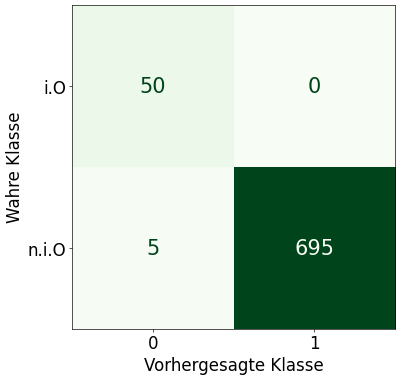

In [58]:
ch.plot_calc_cm(y_test0, y_pred0, class_name=["i.O", "n.i.O"], dpi=60)

In [59]:
def collect_results(clf, y_true, y_pred, algorithm, params, best_param):
    
    res = {"algorithm":algorithm, "params":params, "best_param":best_param,
           "rec_0":None, "pre_0":None, "f1_0":None, "rec_weighted":None, "pre_weighted":None, "f1_weighted":None, "acc":None}
    
    y_true0 = ch.swap_zero_one(y_true, 0)
    y_pred0 = ch.swap_zero_one(y_pred, 0)
    
    res["rec_0"] = recall_score(y_true0, y_pred0)
    res["pre_0"] = precision_score(y_true0, y_pred0)
    res["f1_0"] = f1_score(y_true0, y_pred0)
    res["rec_weighted"]= recall_score(y_true, y_pred, average='weighted')
    res["f1_weighted"]= f1_score(y_true, y_pred, average='weighted')
    res["pre_weighted"]= precision_score(y_true, y_pred, average='weighted')
    res["acc"] = accuracy_score(y_true, y_pred)
    
    for val in res.keys():
        if res[val]==None:
            print("somethong is wrong")
    
    return res

In [60]:
res = collect_results(best_clf, y_test, y_pred, algorithm="svm", params=parameters, best_param=search.best_params_)
res

{'algorithm': 'svm',
 'params': {'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
  'classifier__C': [0.01, 0.1, 1.0, 10, 50, 100],
  'classifier__gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1, 1, 10]},
 'best_param': {'classifier__C': 0.01,
  'classifier__gamma': 'auto',
  'classifier__kernel': 'poly'},
 'rec_0': 0.9928571428571429,
 'pre_0': 1.0,
 'f1_0': 0.996415770609319,
 'rec_weighted': 0.8566666666666667,
 'pre_weighted': 0.8947915548210165,
 'f1_weighted': 0.8745295448341224,
 'acc': 0.708}

In [61]:
filename = "mlc_ml_br_hyperopt_results_v2.4.json"
key_algorithm = "svm"
hyperopt_result = res

In [62]:
if os.path.exists(f"results/{filename}") == False:
    with open(f"results/{filename}", "w") as f:
        json.dump({f"{key_algorithm}":hyperopt_result}, f)
        f.close()
else:
    with open(f"results/{filename}", "r") as f:
        data = json.load(f)
        data.update({f"{key_algorithm}":hyperopt_result})
        
    with open(f"results/{filename}", "w") as f:
        json.dump(data, f)
        f.close()